# Chapter 6

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import interp
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, confusion_matrix, f1_score, make_scorer, precision_score, recall_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, StratifiedKFold, train_test_split, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

plt.style.use({'figure.facecolor': 'white'})

## 6.1

In [9]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)
print(le.transform(["M", "B"]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1, solver="lbfgs"))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print("Test Accuracy: %.3f" % pipe_lr.score(X_test, y_test))

['B' 'M']
[1 0]
Test Accuracy: 0.956


## 6.2

In [17]:
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print("Fold: %2d, Class dist.: %s, Acc: %.3f" % (k+1, np.bincount(y_train[train]), score))
print("\nCV accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print("CV accuracy scores: %s" % scores)
print("\nCV accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.014
CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]

CV accuracy: 0.950 +/- 0.014


## 6.3

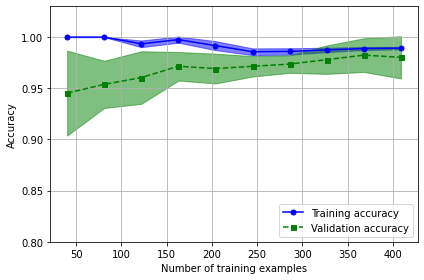

In [20]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", random_state=1, solver="lbfgs", max_iter=10000))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color="blue", marker="o", markersize=5, label="Training accuracy")
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.5, color="blue")
plt.plot(train_sizes, test_mean, color="green", linestyle="--", marker="s", markersize=5, label="Validation accuracy")
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.5, color="green")
plt.grid()
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

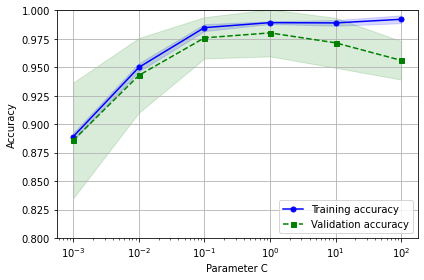

In [22]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name="logisticregression__C", param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color="blue", marker="o", markersize=5, label="Training accuracy")
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color="blue")
plt.plot(param_range, test_mean, color="green", linestyle="--", marker="s", markersize=5, label="Validation accuracy")
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green")
plt.grid()
plt.xscale("log")
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

## 6.4

In [28]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{"svc__C": param_range, "svc__kernel": ["linear"]},
              {"svc__C": param_range, "svc__gamma": param_range, "svc__kernel": ["rbf"]}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring="accuracy", cv=10, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print("Test accuracy: %.3f" % clf.score(X_test, y_test))

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Test accuracy: 0.974


In [30]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring="accuracy", cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring="accuracy", cv=5)
print("CV accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid=[{"max_depth": [1, 2, 3, 4, 5, 6, 7, None]}], scoring="accuracy", cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring="accuracy", cv=5)
print("CV accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV accuracy: 0.974 +/- 0.015
CV accuracy: 0.934 +/- 0.016


## 6.5

[[71  1]
 [ 2 40]]


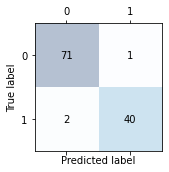

In [36]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

In [40]:
print("Precision: %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
print("Recall: %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
print("F1: %.3f" % f1_score(y_true=y_test, y_pred=y_pred))

c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [{"svc__C": c_gamma_range, "svc__kernel": ["linear"]},
              {"svc__C": c_gamma_range, "svc__gamma": c_gamma_range, "svc__kernel": ["rbf"]}]
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

Precision: 0.976
Recall: 0.952
F1: 0.964
0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


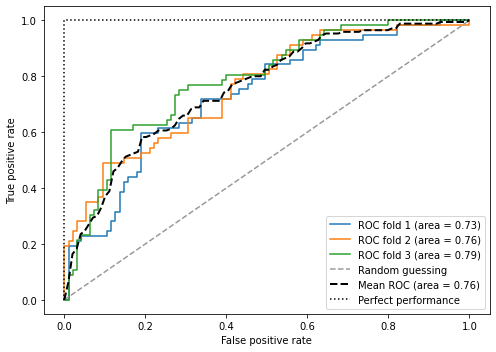

In [42]:
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty="l2", random_state=1, solver="lbfgs", C=100.0))
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="ROC fold %d (area = %0.2f)" % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle="--", color=(0.6, 0.6, 0.6), label="Random guessing")
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, "k--", label="Mean ROC (area = %0.2f)" % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=":", color="black", label="Perfect performance")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 6.6


In [45]:
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))

y_pred = np.zeros(y_imb.shape[0])
print(np.mean(y_pred == y_imb) * 100)

print("Number of class 1 examples before: ", X_imb[y_imb == 1].shape[0])
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1], replace=True, n_samples=X_imb[y_imb == 0].shape[0], random_state=123)
print("Number of class 1 examples after: ", X_upsampled.shape[0])

X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))
y_pred = np.zeros(y_bal.shape[0])
print(np.mean(y_pred == y_bal) * 100)


89.92443324937027
Number of class 1 examples before:  40
Number of class 1 examples after:  357
50.0
